# CART / Random forest
#### CART (classification and regression trees)

In [1]:
import pandas as pd
import numpy as np
from sklearn import tree

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import math as m

from IPython.display import SVG
from IPython.display import display
from graphviz import Source

In [2]:
from IPython.display import HTML
style = "<style>svg{width:70% !important; height: 70% !important;}</style>"
HTML(style)

In [3]:
# Implementing cross-validation
from sklearn.model_selection import cross_val_score

### Data Description

About dataset :
World Health Organization has estimated 12 million deaths occur worldwide, every year due to Heart diseases. 
Half the deaths in the United States and other developed countries are due to cardio vascular diseases. 
The early prognosis of cardiovascular diseases can aid in making decisions on lifestyle changes in high risk patients and in turn reduce the complications. 
This research intends to pinpoint the most relevant/risk factors of heart disease as well as predict the overall risk using logistic regression.

Full description:</br>
https://www.who.int/en/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds)

```
List of columns
sex:             male or female
age:             age of the patient
currentSmoker:   whether or not the patient is a current smoker
cigsPerDay:      the number of cigarettes that the person smoked on average in one day
BPMeds:          whether or not the patient was on blood pressure medication
prevalentStroke: whether or not the patient had previously had a stroke
prevalentHyp:    whether or not the patient was hypertensive
diabetes:        whether or not the patient had diabetes
totChol:         total cholesterol level
sysBP:           systolic blood pressure
diaBP:           diastolic blood pressure
BMI:             Body Mass Index
heartRate:       heart rate
glucose:         glucose level

TARGET COLUMN:
TenYearCHD       10 year risk of coronary heart disease CHD
```

In [4]:
# Loading test dataframe
test_df = pd.read_csv('./framingham.csv')
test_df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


### Loading train dataframe

In [5]:
train_df = pd.read_csv('./framingham.csv')
train_df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


### Find Null values

In [6]:
train_df.isnull().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

### Filter our features - X and the point - y
### X = train_df.drop(['male', 'age', 'currentSmoker', 'cigsPerDay', 'heartRate'], axis=1)

In [7]:
X = train_df.drop(['TenYearCHD'], axis=1)
y = train_df.TenYearCHD

In [8]:
# Delete strings variables
X = pd.get_dummies(X)
X.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0


### Fill Nan values by median to get rid of them

In [9]:
median = X.age.median()
X = X.fillna(median)
X.isnull().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
dtype: int64

### Create decision tree classifyer

Entropy is an information theory metric that measures the impurity or uncertainty in a group of observations. It determines how a decision tree chooses to split data. The image below gives a better description of the purity of a set.

![entropy](entropy.png)

### Information Gain

Information gain as a measure of how much information a feature provides about a class. Information gain helps to determine the order of attributes in the nodes of a decision tree.

The main node is referred to as the parent node, whereas sub-nodes are known as child nodes. We can use information gain to determine how good the splitting of nodes in a decision tree.

![gain](gain.png)

In [10]:
clf = tree.DecisionTreeClassifier(criterion='entropy')

In [11]:
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy')

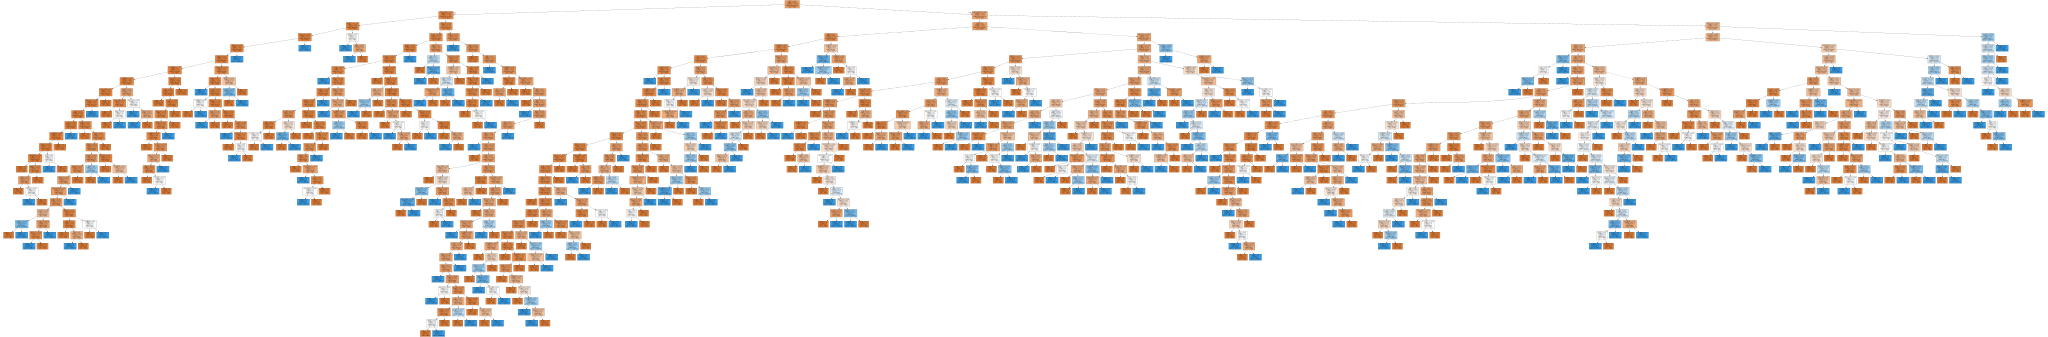

In [12]:
graph = Source(tree.export_graphviz(clf, out_file=None,
                                    feature_names=list(X),
                                    class_names=['Died', 'Survived'],
                                    filled=True))
display(SVG(graph.pipe(format='svg')))

### Learn model on testing data

In [13]:
from sklearn.model_selection import train_test_split

### Test size = 33%

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [15]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [16]:
clf.score(X_train, y_train)

1.0

In [17]:
clf.score(X_test, y_test)

0.7612580414581844

#### Limit decision tree deep

In [18]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [19]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [20]:
clf.score(X_train, y_train)

0.8485382176822825

In [21]:
clf.score(X_test, y_test)

0.852037169406719

In [22]:
scores_data = pd.DataFrame()

### Find optimal paramenets

In [23]:
max_depth_values = range(1, 50)
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    mean_cross_val_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    
    temp_dataframe = pd.DataFrame({'max_depth': [max_depth], 
                                   'train_score': train_score, 
                                   'test_score': test_score,
                                   'cross_val_score': [mean_cross_val_score]})
    
#     scores_data = scores_data.append(temp_dataframe)
    scores_data = pd.concat([scores_data, temp_dataframe])

In [24]:
scores_data.head()

,max_depth,train_score,test_score,cross_val_score
0,1,0.845368,0.853467,0.845369
0,2,0.845368,0.853467,0.845369
0,3,0.848538,0.852037,0.838323
0,4,0.854174,0.848463,0.840436
0,5,0.858049,0.846319,0.837267


### Rebuild DataFrame

In [25]:
scores_data_long = pd.melt(scores_data, 
                                    id_vars=['max_depth'], 
                                    value_vars=['train_score', 'test_score', 'cross_val_score'],
                                    var_name='set_type', 
                                    value_name='score')
scores_data_long.query('set_type == "cross_val_score"').head(10)

,max_depth,set_type,score
98,1,cross_val_score,0.845369
99,2,cross_val_score,0.845369
100,3,cross_val_score,0.838323
101,4,cross_val_score,0.840436
102,5,cross_val_score,0.837267
103,6,cross_val_score,0.825646
104,7,cross_val_score,0.822828
105,8,cross_val_score,0.821063
106,9,cross_val_score,0.821068
107,10,cross_val_score,0.812264


<AxesSubplot:xlabel='max_depth', ylabel='score'>

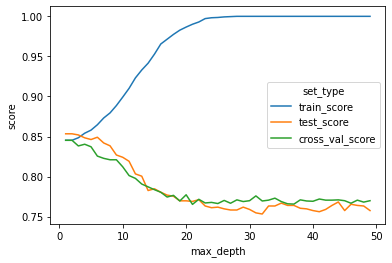

In [26]:
sns.lineplot(data=scores_data_long, x='max_depth', y='score', hue='set_type')

In [27]:
best_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10)

#### Cross-valididation with folds strategy. CV means amount of folds

In [28]:
cross_val_score(best_clf, X_test, y_test, cv=5).mean()

0.7777035330261135

In [29]:
from sklearn.model_selection import GridSearchCV

In [30]:
parameters = {'criterion': ['gini', 'entropy'], 'max_depth': range(1, 30)}

## Create Grid|SearchCV classifier

In [31]:
clf = tree.DecisionTreeClassifier()
grid_search_cv_clf = GridSearchCV(clf, parameters, cv=5)

In [32]:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30)})

In [33]:
grid_search_cv_clf.best_params_

{'criterion': 'gini', 'max_depth': 2}

In [34]:
best_clf = grid_search_cv_clf.best_estimator_

#### Best classifier

In [35]:
best_clf.score(X_test, y_test)

0.852037169406719

In [36]:
from sklearn.metrics import precision_score, recall_score

#### Prediction probability: true/false array

In [37]:
y_pred_probabilities = best_clf.predict(X_test)
y_pred_probabilities

array([0, 0, 0, ..., 0, 0, 0])

### Find precission

In [38]:
precision_score(y_test, best_clf.predict(X_test), average='macro')

0.4266284896206156

### Find recall

In [39]:
recall_score(y_test, best_clf.predict(X_test), average='macro')

0.4991624790619765

In [40]:
y_pred_probability = best_clf.predict_proba(X_test)
y_pred_probability[0:9]

array([[0.80847308, 0.19152692],
       [0.9247626 , 0.0752374 ],
       [0.80847308, 0.19152692],
       [0.9247626 , 0.0752374 ],
       [0.9247626 , 0.0752374 ],
       [0.80847308, 0.19152692],
       [0.80847308, 0.19152692],
       [0.80847308, 0.19152692],
       [0.80847308, 0.19152692]])

<AxesSubplot:>

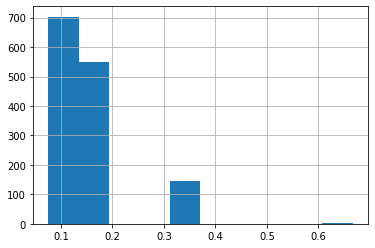

In [41]:
pd.Series(y_pred_probability[:, 1]).hist()

### If probability > 0.8 => 1, else 0

In [42]:
y_pred_1 = np.where(y_pred_probability[:, 1] > 0.8, 1, 0)

<AxesSubplot:>

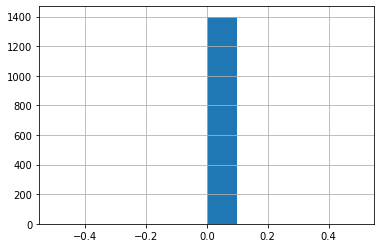

In [43]:
pd.Series(y_pred_1).hist()

### Find precission

In [44]:
precision_score(y_test, y_pred_1, average='macro')

/home/mono/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4267333809864189

### Find recall

In [45]:
recall_score(y_test, y_pred_1, average='macro')

0.5

### If probability > 0.2 => 1, else 0

In [46]:
y_pred_2 = np.where(y_pred_probability[:, 1] > 0.2, 1, 0)

### Find precission

In [47]:
precision_score(y_test, y_pred_2, average='macro')

0.6069684792706376

### Find recall

In [48]:
recall_score(y_test, y_pred_2, average='macro')

0.5809126935490461

### ROC curve

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

- True Positive Rate
- False Positive Rate


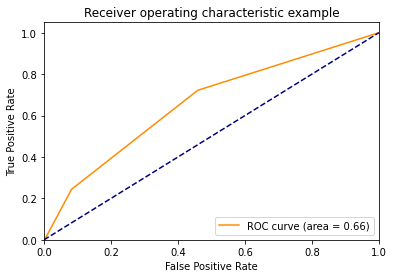

In [49]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probability[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Add a limit for our decision tree

min_samples_split=100 - If amout of elemets less than 100 don't conunt it as a branch

In [50]:
clf = tree.DecisionTreeClassifier(criterion='entropy', 
                                  max_depth=3,
                                  min_samples_split=100,
                                  min_samples_leaf=10)
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=10,
                       min_samples_split=100)

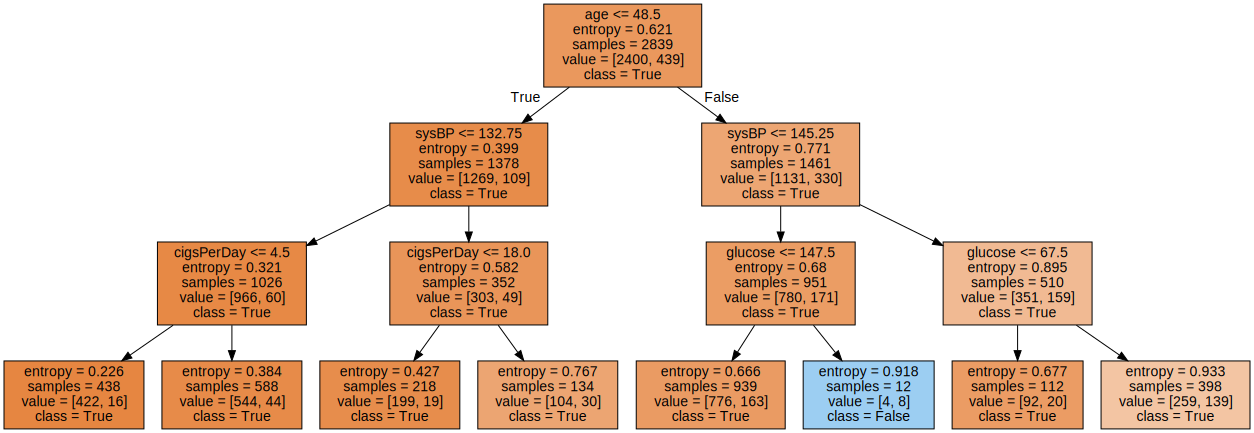

In [51]:
graph = Source(tree.export_graphviz(clf, out_file=None,
                                    feature_names=list(X),
                                    class_names=['True', 'False'],
                                    filled=True))
display(SVG(graph.pipe(format='svg')))

## Create random forest classifier

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
clf_rf = RandomForestClassifier()
parametrs = {'n_estimators': [10,20,30], 'max_depth': [2,5,7,10]}

grid_search_cv_clf = GridSearchCV(clf_rf, parametrs, cv=5)

In [54]:
grid_search_cv_clf.fit(X_train, y_train)
grid_search_cv_clf.best_params_

{'max_depth': 2, 'n_estimators': 10}

### Testing of a best clasifier
#### The result must be better than decision tree result

In [55]:
best_clf = grid_search_cv_clf.best_estimator_
best_clf.score(X_test, y_test)

0.8534667619728378

### Feature inmportance

In [56]:
feature_importances = best_clf.feature_importances_
feature_importances_df = pd.DataFrame({'features':list(X_train.columns), 
                                       'feature_importances':  best_clf.feature_importances_})\
                        .sort_values(by='feature_importances', ascending=False)
feature_importances_df

,features,feature_importances
10,sysBP,0.290543
1,age,0.236886
7,prevalentHyp,0.179525
2,education,0.083539
9,totChol,0.061763
14,glucose,0.057922
11,diaBP,0.055585
12,BMI,0.015356
13,heartRate,0.011943
8,diabetes,0.006939


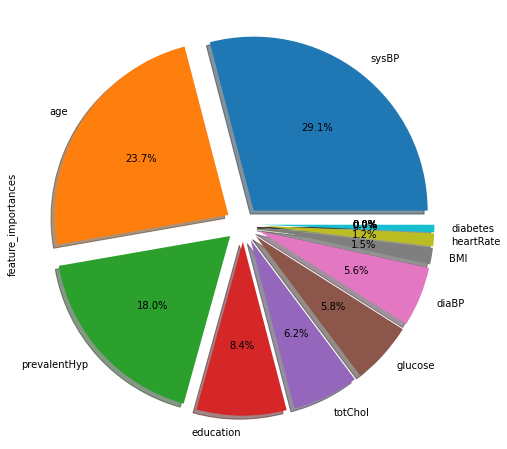

In [57]:
feature_importances_df.plot.pie(
                        explode=[0.1]*len(X_train.columns),
                        labels = feature_importances_df.features,
                        y = 'feature_importances',
                        autopct='%1.1f%%',
                        shadow=True,
                        legend=False,
                        figsize=(8, 8));